In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.transforms import v2
import numpy as np
# import PIL

In [2]:
torchvision.__version__

'0.16.0'

## Import data

In [3]:
folder="./dataset"
# transform = transforms.Compose([transforms.ToTensor()])
data_train_val=torchvision.datasets.FashionMNIST(root=folder,train=True,download=True,transform=None)
data_test=torchvision.datasets.FashionMNIST(root=folder,train=False,download=True,transform=None)
classes=data_test.classes

### 1. Data Preparation (10 points)
- (a) Data cleansing and transformation (5 points)

In [4]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, trans=None):
        self.x = inputs
        self.y = targets
        self.trans=trans

    def __len__(self):
        return self.x.size()[0]

    def __getitem__(self, idx):

        if self.trans == None:
            # print("no trans")
            return ( self.x[idx], self.y[idx])
        else:
            # print("trans")
            return ( self.trans(self.x[idx]), self.y[idx]) 

def ds_trans(ds_input,trans_flag):
    data_input=ds_input.data.clone().detach()
    labels_input=ds_input.targets
    if data_input.ndim <= 3:
        transform_train_val = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)), 
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomAffine(degrees=(0,3), translate=(0,0.05), scale=None, shear=(0,0.05)),
            transforms.RandomResizedCrop(size=(64,64),scale=(0.9,1.0),ratio=(0.9,1.1)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)
        ])
        transform_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)), 
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)
        ])
    elif data_input.ndim == 4:
        # Should not come here
        print("WRONG!")

    if torch.isnan(data_input).any():
        print("have NaN or Inf")
    data_input = data_input[:,None,:,:]
    print(data_input.shape)
    
    if trans_flag==1:
        flag_ds_new = dataset(data_input, labels_input, trans=transform_train_val)
    elif trans_flag==2:
        flag_ds_new = dataset(data_input, labels_input, trans=transform_test)
    else:
        flag_ds_new = dataset(data_input, labels_input, trans=None)
    return (flag_ds_new)
    

In [5]:
ds_processed_train_val=ds_trans(ds_input=data_train_val,trans_flag=1)
ds_processed_test=ds_trans(ds_input=data_test,trans_flag=2)
# ds_processed.x.shape

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


- (b) Data splitting (i.e., training, validation, and test splits) (5 points)

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

random_seed=22
indices = list(range(data_train_val.targets.shape[0]))
np.random.seed(random_seed)
np.random.shuffle(indices)

indices_train=indices[:50000]
indices_val=indices[50000:]

ds_processed_train_sampler=SubsetRandomSampler(indices_train)
ds_processed_val_sampler=SubsetRandomSampler(indices_val)

# batch_size=64
batch_size=256
num_workers=10
loader_train = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_train_sampler,
                                            num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_val_sampler,
                                            num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(ds_processed_test, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

In [7]:
for batch_idx, (inputs, targets) in enumerate(loader_train):
    break
print(inputs.shape)
print(targets.shape)

torch.Size([256, 1, 64, 64])
torch.Size([256])


## 2. Plot Sample Image

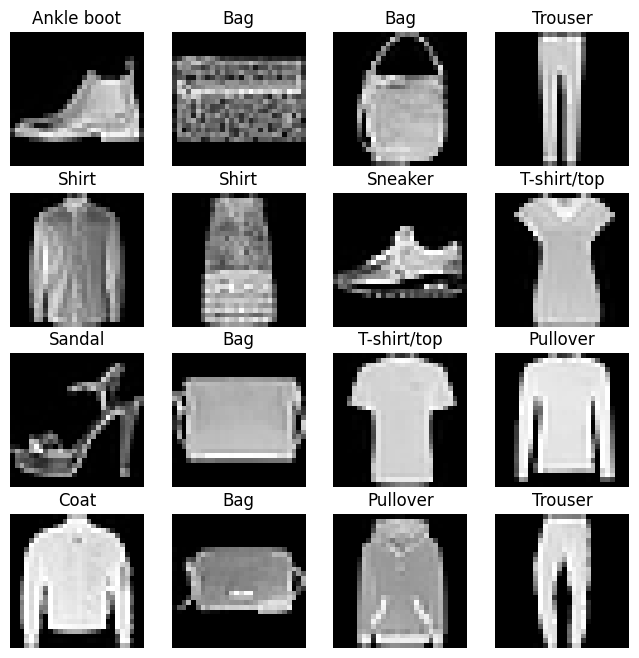

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (8,8))
cols, rows = 4, 4
ids=torch.randint(len(data_test), size = (cols*rows,))
for i in range (1, cols*rows + 1):
    image, label = data_test[ids[i-1].item()]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis('off')
    # plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image, cmap='gray')
    # plt.imshow(image.squeeze())
plt.show()
classes

## 3. Model Selection (20 points)
- (a) Algorithm selection: SqueezeNet
- (b) Model building: Developing and tuning selected model (Select best learning rate and optimizer)
- (c) Model evaluation: Proper evaluation metrics (i.e., accuracy, precision, recall, F1-score) and qualitative analysis (i.e., confusion matrices) for classification on test set. (5 points)

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def trainloop (dataloader, model, loss_fn, optimizer,device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        
        # Compute the error rate
        prediction = model(X)
        loss = loss_fn(prediction, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')
            
def evaluate (dataloader, model, loss_fn,device):
    # size = len(dataloader.dataset)
    size = len(dataloader.sampler)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    Y_pred=[]
    Y_true=[]
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            Y_pred.append(pred.argmax(1).cpu().numpy())
            Y_true.append(y.cpu().numpy())
    test_loss /= num_batches
    correct /= size
    print(f'Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    accuracy=100*correct
    Y_pred=np.concatenate(Y_pred)
    Y_true=np.concatenate(Y_true)
    accuracy2=accuracy_score(Y_true,Y_pred)
    # print(f'Accuracy2: {(accuracy2*100):>0.1f}')
    precision = precision_score(Y_true, Y_pred, average='macro')
    recall = recall_score(Y_true, Y_pred, average='macro')
    f1 = f1_score(Y_true, Y_pred, average='macro')
    cm = confusion_matrix(Y_true, Y_pred)
    print("accuracy, precision, recall, f1, test_loss:")
    print(accuracy, precision, recall, f1, test_loss)
    return [accuracy, precision, recall, f1, test_loss], cm

## Retrain model with the best learning rate and optimizer
We retrain the model because in the cross validation we don't use the validation dataset for training. For the purpose of the best usage of dataset, we use all 60000 dataset in previous training and validation to train the model, and then estimate the final performance on the testing dataset.

In [10]:
def build_train_best_model(loader_train,loader_test,learning_rate,id_optimizer):
    device ='cuda' if torch.cuda.is_available else 'cpu'
    print(f'Using {device} device')

    # You can try different if necessary
    
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
    # model=torchvision.models.vgg11()
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights='DenseNet121_Weights.IMAGENET1K_V1')
    model=torchvision.models.squeezenet1_0(weights='SqueezeNet1_0_Weights.IMAGENET1K_V1')
    
    # model
    # model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # vgg
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) # densenet121
    model.features[0]=torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2)) # SqueezeNet

    model=model.to(device)
    # model

    # Define hyperparameters
    # learning_rate = 1e-4
    epochs = 100

    # Loss Function
    loss_fn = nn.CrossEntropyLoss()

    # Optimizer
    if id_optimizer==0:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif id_optimizer==1:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif id_optimizer==2:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # Training loop
    for i in range(epochs):
        print(f"Epoch {i+1}")
        # print(f"Epoch {i+1}\n-------------------------------")
        trainloop(loader_train, model, loss_fn, optimizer,device)
        # trainloop(loader_test, model, loss_fn, optimizer,device) # for testing

        if i%25==0:
            print("Training Dataset Error:")
            evaluate(loader_train, model, loss_fn,device)
            print("Test Dataset Error:");
            evaluate(loader_test, model, loss_fn,device)

    print("Training Dataset Error:")
    result_train,cm_train=evaluate(loader_train, model, loss_fn,device)
    print("Testing Dataset Error:");
    result_test,cm_test=evaluate(loader_test, model, loss_fn,device)

    results=[result_train,result_test]

    return model

In [11]:
loader_train_all=torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)
learning_rate=1e-3
id_optimizer=0
model_best=build_train_best_model(loader_train_all,loader_test,learning_rate,id_optimizer)



Using cuda device
Epoch 1
loss:17.225590 [    0/60000]
loss:0.902296 [25600/60000]
loss:0.723794 [51200/60000]
Training Dataset Error:
Accuracy: 76.9%, Avg loss: 0.607505 

accuracy, precision, recall, f1, test_loss:
76.92 0.7786653378704618 0.7692 0.7533675667195068 0.6075053873214316
Test Dataset Error:
Accuracy: 75.5%, Avg loss: 0.647284 

accuracy, precision, recall, f1, test_loss:
75.52 0.7822344744006001 0.7552 0.7383606805569625 0.6472840823233128
Epoch 2
loss:0.737088 [    0/60000]
loss:0.478971 [25600/60000]
loss:0.365290 [51200/60000]
Epoch 3
loss:0.426358 [    0/60000]
loss:0.345666 [25600/60000]
loss:0.540306 [51200/60000]
Epoch 4
loss:0.392383 [    0/60000]


## Prediction for a single image

7208
label_pred:  5
label_treu:  5


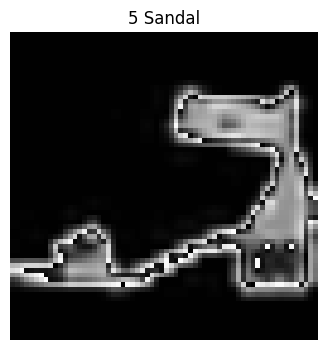

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (4,4))
cols, rows = 1, 1
ids=torch.randint(len(data_test), size = (cols*rows,))

print(ids.item())


image_tensor,label_tensor=ds_processed_test[ids.item()]
image=transforms.ToPILImage()(image_tensor[0,:,:])
image_tensor=image_tensor[None,:,:,:]
label=label_tensor.item()

model=model_best
model.eval()
# model.train()
device='cuda'
X,y = image_tensor.to(device),label_tensor.to(device)
# X=X[None,:,:,:]
pred = model(X)
label_pred=pred.argmax(1).item()
print("label_pred: ",label_pred)
print("label_treu: ", label)

figure.add_subplot(rows, cols, 1)
plt.title(str(label)+" "+classes[label])
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.show()